In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import math
import pandas as pd

from collections import Counter

%matplotlib inline
plt.rcParams['figure.figsize'] = (16,10)

# Things that are about 8kb long

Sequences for the Covid-19 virus are widely published and there are many great resources for analyzing them, this is not one of them! If you are interested in the genetics of the virus, see for example

 * [nextstrain.org](https://nextstrain.org/) can show you the "family tree" of COVID-19 and other viruses
 

Instead, this notebook explores the surprising fact (for me!) that the sequence length is about $2^{15}$ base pairs, or looked at another way, around $8\textrm{kb}$. I first saw this fact (and the first visualization below) in [this reddit post](https://www.reddit.com/r/dataisbeautiful/comments/fkwova/oc_rna_sequence_of_covid19_this_8kb_of_data_is/), which links to [this data set](https://www.ncbi.nlm.nih.gov/nuccore/MN908947.3). The data at the bottom of that page be massaged with `sed` and `tr` to produce the file [cov.ascii](./cov.ascii) included in this repository.



### COVID-19 genetic sequence as a heatmap

For this visualization, we are taking the sequence "gataca...", squashing that sequence into a roughly square shape then plotting the result as a heatmap.

In [2]:
with open('cov.ascii', 'r') as f:
    covid_txt = f.read()[:-1]

In [3]:
covid_num = np.array([ord(c) for c in covid_txt])

In [4]:
nearest_sq = math.ceil(np.sqrt(len(covid_num)))

In [5]:
covid_num = np.pad(covid_num, (0, nearest_sq**2 - len(covid_num)))
covid_num = covid_num.reshape(nearest_sq, nearest_sq)

In [6]:
covid_num = np.where(covid_num == 97, 100, covid_num)
covid_num = np.where(covid_num == 99, 125, covid_num)
covid_num = np.where(covid_num == 103, 150, covid_num)
covid_num = np.where(covid_num == 116, 200, covid_num)

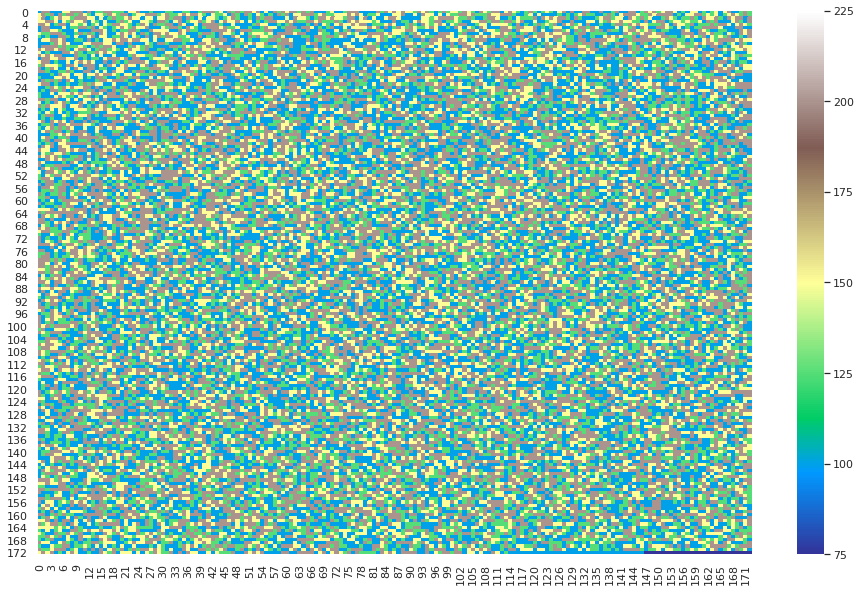

In [7]:
sns.heatmap(covid_num, vmin=75, vmax=225, cmap='terrain')

<BarContainer object of 4 artists>

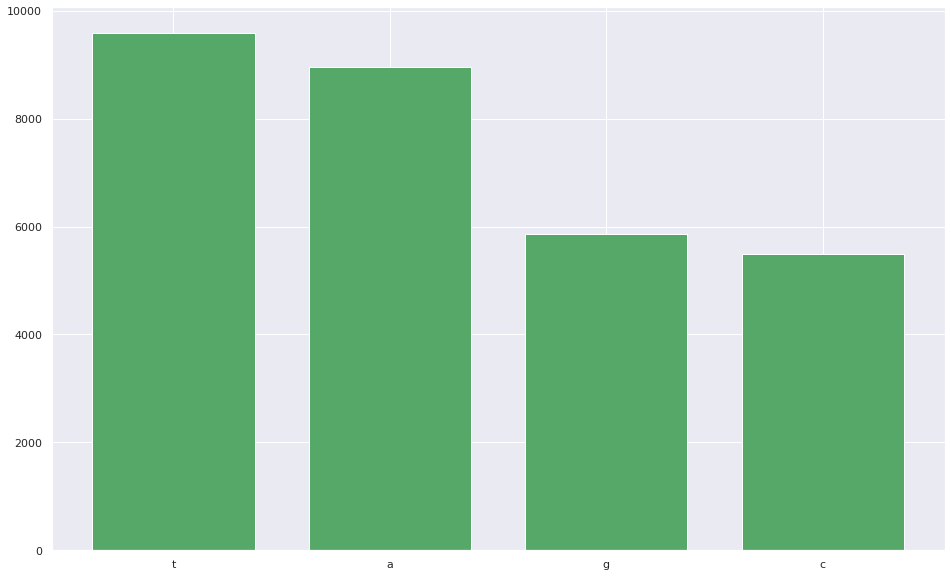

In [8]:
c = Counter(covid_txt)
plt.bar(*zip(*c.most_common()), width=.75, color='g')

In [9]:
covidDF = pd.DataFrame.from_dict(c,
                              orient='index',
                              columns=['count']
                              ).sort_values(by='count', ascending=False)
covidDF.head()

,count
t,9594
a,8954
g,5863
c,5492


In [10]:
covidDF['rel_freq'] = covidDF['count'] / covidDF['count'].sum()
covidDF

,count,rel_freq
t,9594,0.320837
a,8954,0.299435
g,5863,0.196067
c,5492,0.183661


In [12]:
covidDF['surprise'] = np.log2(1/ covidDF.rel_freq)
covidDF['surprise'].head(n=10)

t    1.640086
a    1.739686
g    2.350579
c    2.444887
Name: surprise, dtype: float64

In [13]:
covid_entropy = - covidDF['rel_freq'] * np.log2(covidDF['rel_freq'])
covid_info = covid_entropy.sum() * len(covid_txt)
print(f"COVID-19: {covid_entropy.sum():.4f} bits per char. Total={covid_info:.4f}")

COVID-19: 1.9570 bits per char. Total=58520.8965


## Random Sequence

Just to hammer home that this isn't a meaningful thing to do, here is the same visualization with purely random choices

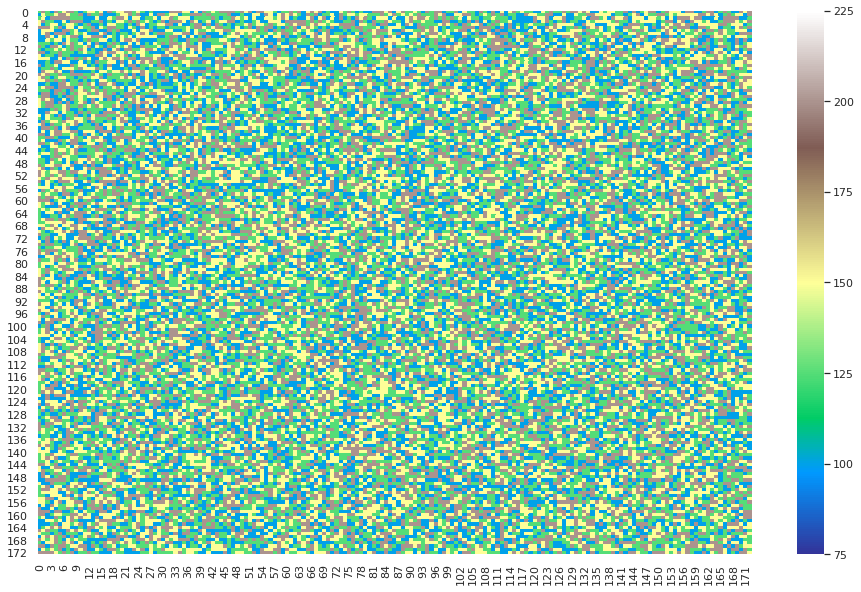

In [14]:
random_num = np.random.choice([100, 125, 150, 200], size=(nearest_sq, nearest_sq))
sns.heatmap(random_num, vmin=75, vmax=225, cmap='terrain')

## Other things that are about 8kb

* The declaration of independence is about 8000 characters long. So if we take each character as a single ascii byte...

In [15]:
with open('doi.ascii', 'r') as f:
    doi_txt = f.read()[:-1].lower().replace('\n', ' ')

<BarContainer object of 38 artists>

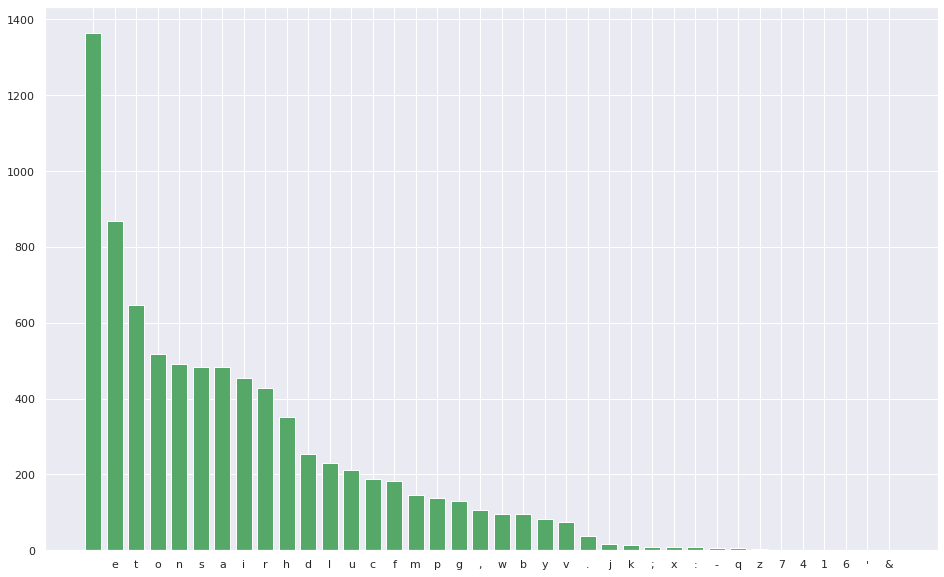

In [16]:
c = Counter(doi_txt)
plt.bar(*zip(*c.most_common()), width=.75, color='g')

In addition to the lowercase ascii characters (26 of them), we have 4 unique numbers ("July 4th, 1776), and some punctuation. To keep things simple, I want to end up with 32 characters, so let's drop the ampersand, the single quote and the numbers. I find it easier to be explicit about the ones I want to keep

In [17]:
letters = [' ', ',', '.', '-', ':', ';', 
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h',
          'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p',
          'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 
          'y', 'z']

doi_txt = doi_txt.translate(
    {ord(i): None for i in c.keys() if i not in letters}
)
c = Counter(doi_txt)
len(c)

32

In [18]:
doiDF = pd.DataFrame.from_dict(c,
                              orient='index',
                              columns=['count']
                              ).sort_values(by='count', ascending=False)
doiDF.head()

,count
,1365
e,868
t,648
o,518
n,490


In [19]:
doiDF['rel_freq'] = doiDF['count'] / doiDF['count'].sum()
doiDF.head(n=10)

,count,rel_freq
,1365,0.167690
e,868,0.106634
t,648,0.079607
o,518,0.063636
n,490,0.060197
a,483,0.059337
s,483,0.059337
i,455,0.055897
r,429,0.052703
h,352,0.043243


In [20]:
doiDF['surprise'] = np.log2(1/ doiDF.rel_freq)
doiDF['surprise'].head(n=10)

     2.576128
e    3.229262
t    3.650963
o    3.974005
n    4.054175
a    4.074934
s    4.074934
i    4.161090
r    4.245979
h    4.531381
Name: surprise, dtype: float64

In [23]:
doi_entropy = - doiDF['rel_freq'] * np.log2(doiDF['rel_freq'])
doi_info = doi_entropy.sum() * len(doi_txt)
print(f"DOI: {doi_entropy.sum():.4f} bits per char. Total={doi_info:.4f}")

DOI: 4.1730 bits per char. Total=33968.4463


So in some sense COVID-19 is better at packing information than the authors of the Declaration of independence.